In [42]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#import paper_tools
import census
import numpy as np
#load the census data
#sheffield
#bbox = np.array([430,440,381,391])
bbox = np.array([433,437,384,388])
pathtodata = '/home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/'
shapefilename=pathtodata+'oaboundaries/Output_Area_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp'
oafilename=pathtodata+'oa_to_lsoa/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv'
randomoafilename = pathtodata+'oa_to_lsoa/RANDOM_SOAS_2.csv' #this file contains MSOA that have been randomly assigned
oadescfilename=pathtodata+'oadata/KS102ew_2011_oa/KS102EW_2011STATH_NAT_OA_REL_1.4.4/KS102EWDESC0.CSV'
oadatafilename=pathtodata+'oadata/KS102ew_2011_oa/KS102EWDATA.CSV'

#X,Y,testX,testY = census.get_census_data(box=bbox*1000,verbose=True)
X,Y,testX,testY = census.get_census_data(shapefilename=shapefilename,
                                         oafilename=oafilename,
                                         oadescfilename=oadescfilename,
                                         oadatafilename=oadatafilename,
                                         box=bbox*1000,verbose=True,refresh=False)
X = np.c_[X,np.zeros([len(X),1])]
testX = np.c_[testX,np.zeros([len(testX),1])]

Trying cache...
Cache loaded.
Loaded from cache, 22 training polygons and 358 testing polygons


In [43]:
X.shape

(22, 2779)

In [44]:
testX.shape

(358, 2779)

In [45]:
Y

array([[ 1135],
       [ 7229],
       [ 8525],
       [ 9152],
       [  597],
       [ 1214],
       [  905],
       [ 7134],
       [ 7464],
       [ 7799],
       [ 9831],
       [ 5511],
       [ 5105],
       [ 8734],
       [ 7966],
       [ 5864],
       [ 1567],
       [12330],
       [ 9106],
       [  409],
       [  999],
       [  400]])

In [48]:
from shapeintegrals_fast_modified_for_hetGP import ShapeIntegral
import GPy
kern = GPy.kern.RBF(2, lengthscale=10.0, variance = 1.0, ARD=False)
oldshapek = ShapeIntegral(X.shape[1],input_space_dim=2,Nperunit=5,kernel=kern)
m = GPy.models.GPRegression(X,Y,oldshapek)
m.Gaussian_noise=10.0
#predY,_=m.predict(testX)#[0:3,:]

 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide


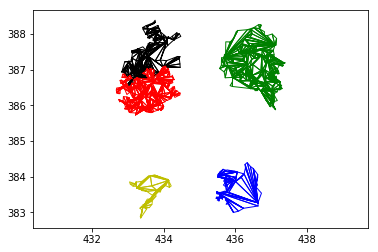

In [49]:
def plotsimplexes(X,c='k',lw=1):
    for x in X:
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.plot(tri[[0,2,4,0]],tri[[1,3,5,1]],c,lw=lw)
        else:
            print("PLOTTING A POINT! AHH")
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)

for i,c in enumerate(['b','k','r','g','y']):
    plotsimplexes(X[i:(i+1),:],c)
plt.axis('equal');

In [ ]:
Xa,Xb = np.meshgrid(np.linspace(432,438,5),np.linspace(383,388,5))
testX = np.c_[Xa.flatten(),Xb.flatten()]
testX = np.c_[testX,np.ones([len(testX),11])]
m.optimize()
preds,_ = m.predict_noiseless(testX)

 /home/mike/Documents/Research/hetMOGPintegral/hetGPIntegralexperiments/shapeintegrals_fast_modified_for_hetGP.py:93: RuntimeWarning:divide by zero encountered in true_divide
